In [1]:
import os
os.chdir('/Users/rv/Projects/7CS074') # Change to the project root directory

# Now we can import the modules
import src.preprocessing as preprocessing
import src.visualisation as visualisation
import src.features as features
import src.models as models

import global_vars 

In [2]:
# First we will check and run the preprocessing script
# In case this is already done, this will not overwrite existing files
preprocessing.process_raw_multiple_data_files()

In [3]:
import pandas as pd

if not os.path.exists(global_vars.DATASET_CLEAN_FILE_PATH):
    raise FileNotFoundError(f"Dataset not found at {global_vars.DATASET_CLEAN_FILE_PATH}. Please ensure the dataset is placed correctly.")

df = pd.read_csv(global_vars.DATASET_CLEAN_FILE_PATH, sep=',', engine='python') # read with proper delimiter handling, and with python engine always
if df.empty:
    raise ValueError("Loaded dataset is empty. Please check the dataset file.")

print(f"Data loaded successfully from {global_vars.DATASET_CLEAN_FILE_PATH}.")

target_col = 'price'
all_models, trained_models_per_make = models.automatic_make_model_selection(
    df,
    target_col=target_col,
    min_samples_per_make=300,
    cv_splits=5
)

Data loaded successfully from /Users/rv/Projects/7CS074/data/clean/cleaned_dataset.csv.


In [6]:
from evaluation import regression_metrics

for make_vehicle, data in all_models.items():
	metrics = data['metrics']
	print(f"Make: {make_vehicle}, MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}, R2: {metrics['R2']}, MAPE: {metrics['MAPE']}")

Make: GLOBAL, MAE: 1308.81291575265, RMSE: 1923.0526576175519, R2: 0.9485192809687963, MAPE: 6.720521560062003
Make: audi, MAE: 1647.6178979820384, RMSE: 2304.4759768412328, R2: 0.8776068805225605, MAPE: 6.460579935589143
Make: bmw, MAE: 1807.2967199683073, RMSE: 2600.119428816479, R2: 0.9088817258941833, MAPE: 6.90557227084552
Make: ford, MAE: 971.2529046022474, RMSE: 1313.3864175636875, R2: 0.902178034514047, MAPE: 6.7632764344780885
Make: hyundi, MAE: 864.4743235254524, RMSE: 1237.096261142454, R2: 0.9400600226058045, MAPE: 6.788320767835178
Make: mercedes, MAE: 1676.3646183171768, RMSE: 2295.1407920255506, R2: 0.9070815871861703, MAPE: 6.3203244855134315
Make: skoda, MAE: 1285.85310530852, RMSE: 1720.312939812188, R2: 0.9254358820727818, MAPE: 7.487185659950739
Make: toyota, MAE: 726.6585356692264, RMSE: 966.4643696721596, R2: 0.8848385922104076, MAPE: 6.430423854671025
Make: vauxhall, MAE: 715.0377441804276, RMSE: 925.3851744479073, R2: 0.8435354378016106, MAPE: 6.579019984682888


audi 20 20


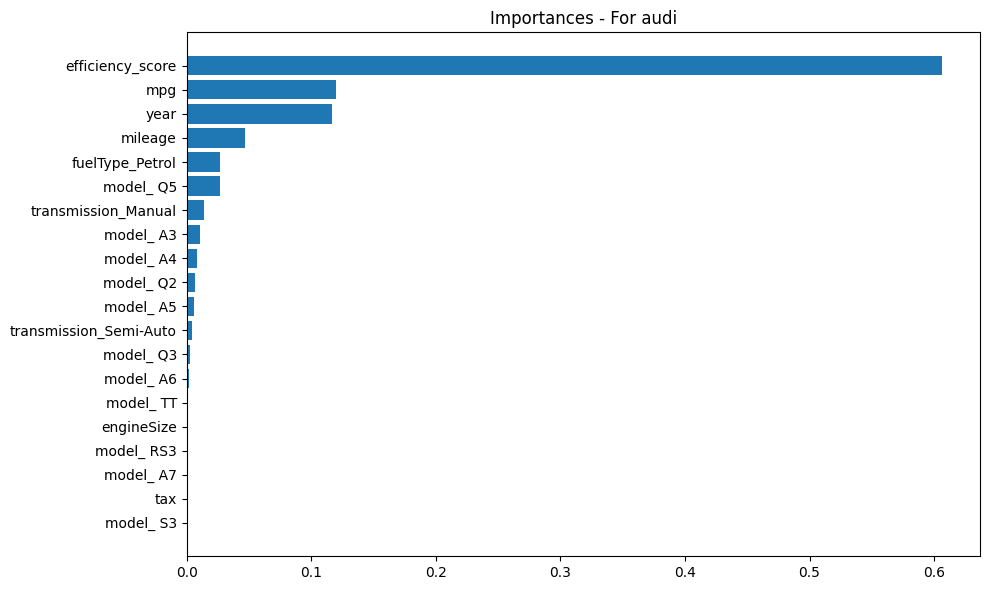

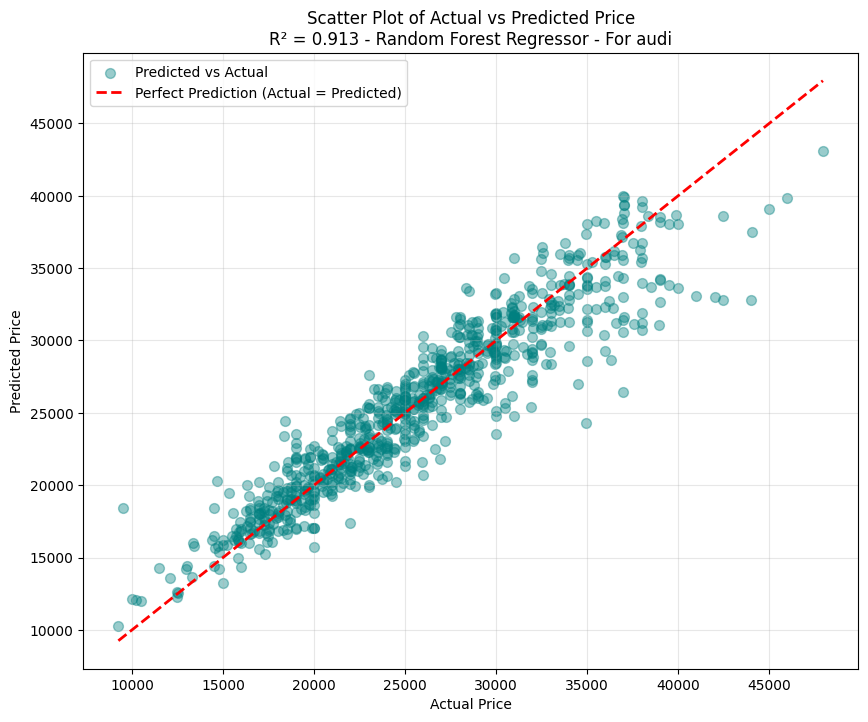

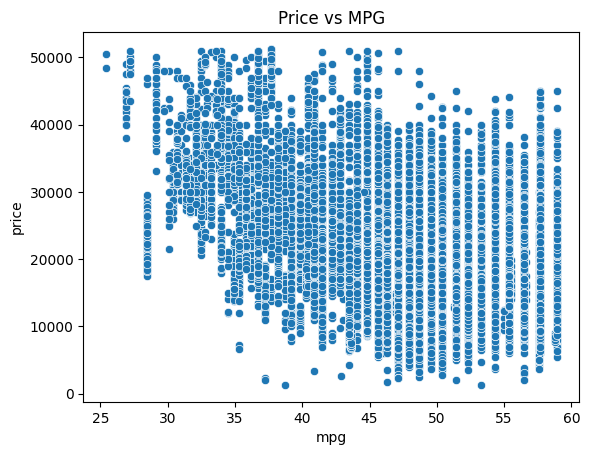

bmw 27 27


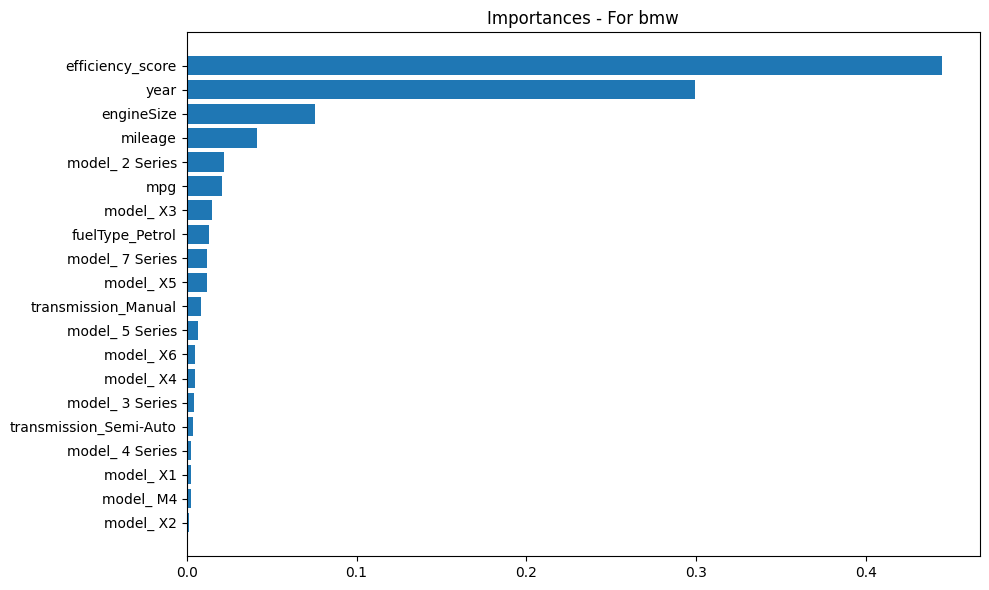

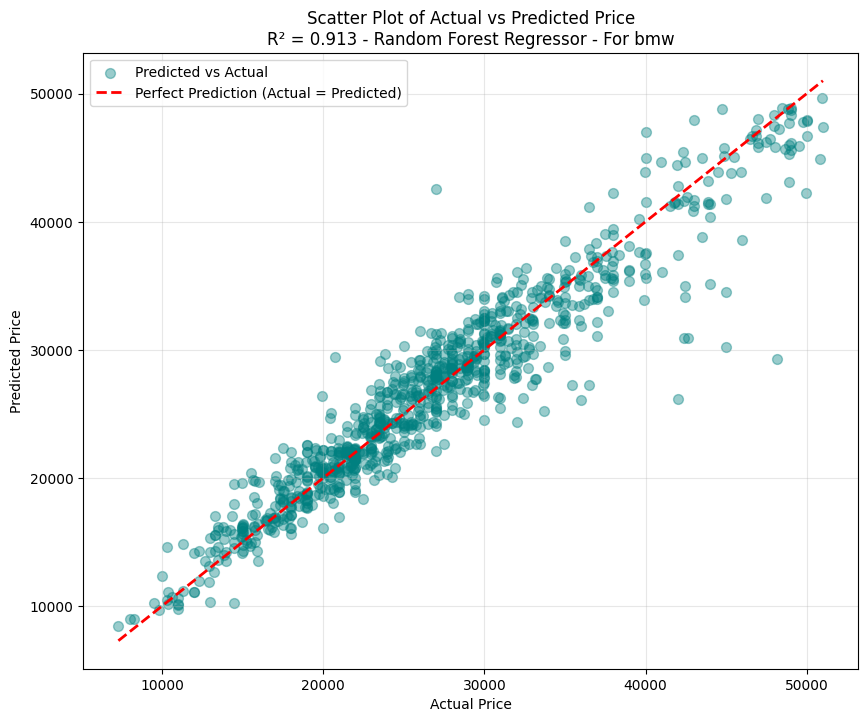

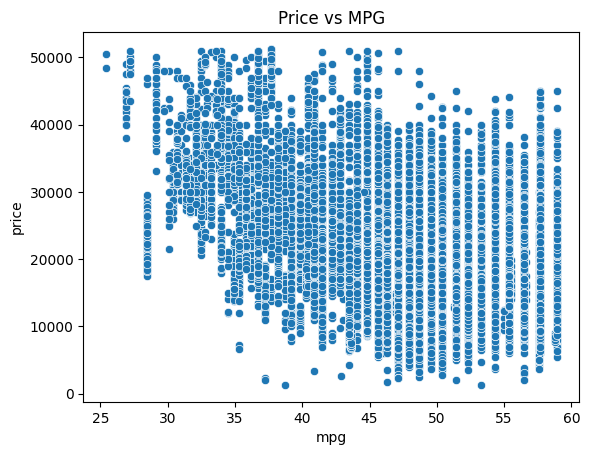

ford 27 27


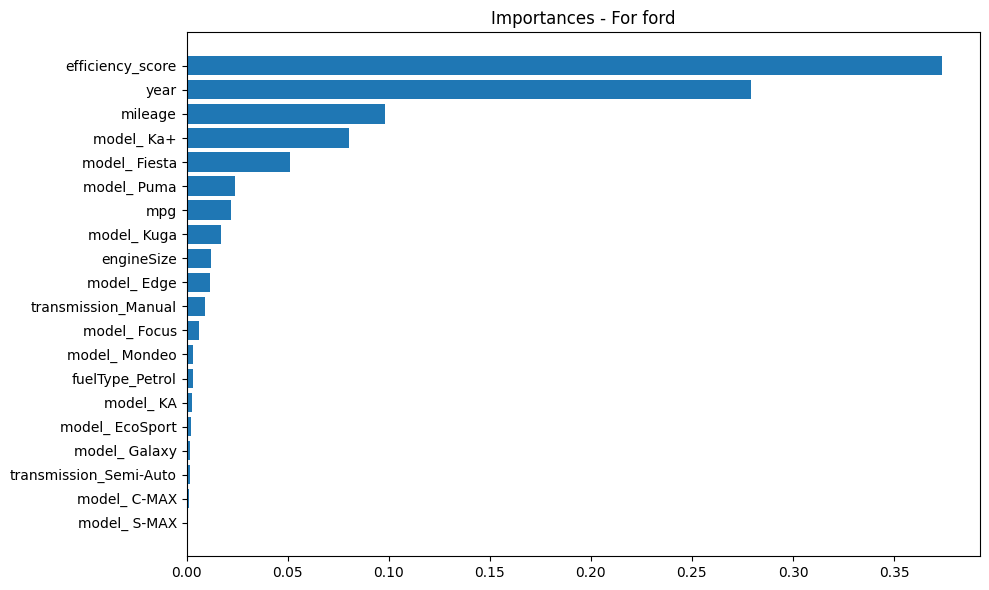

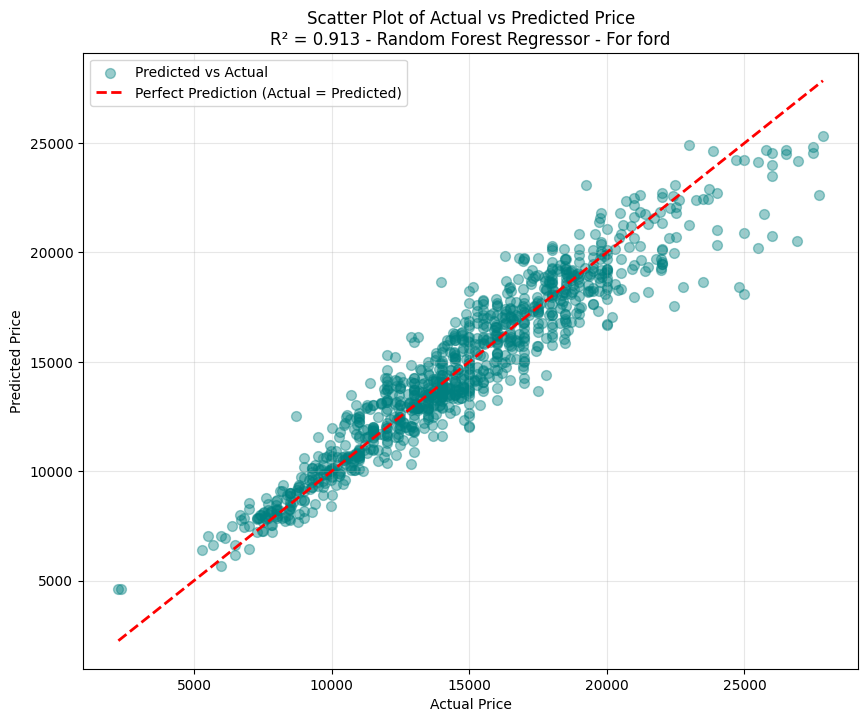

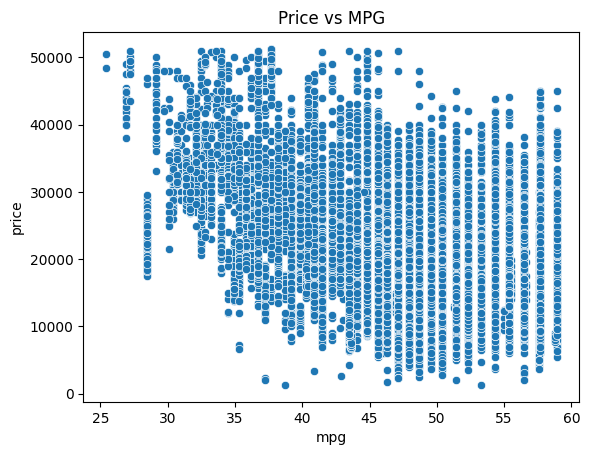

hyundi 23 23


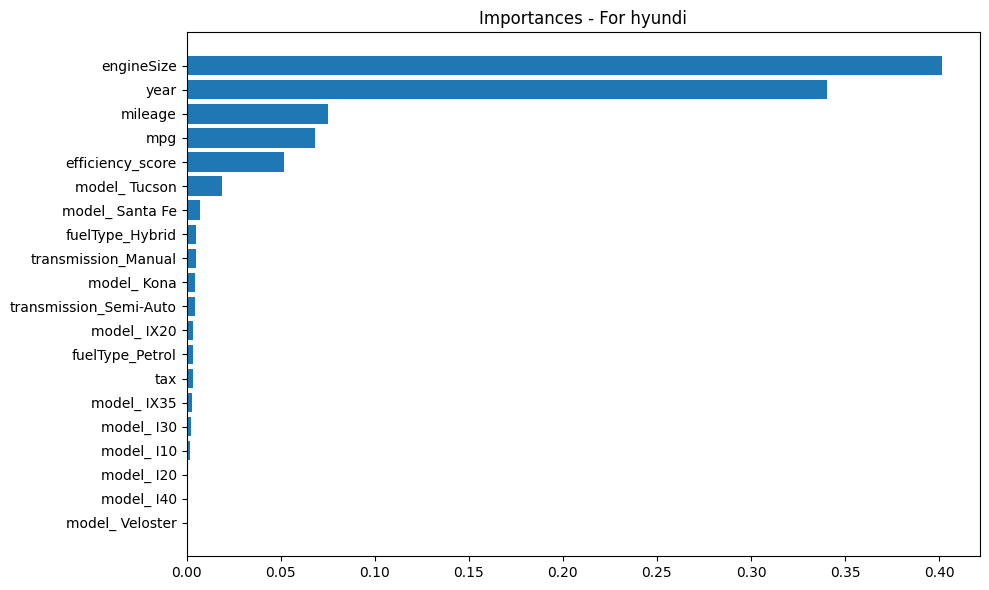

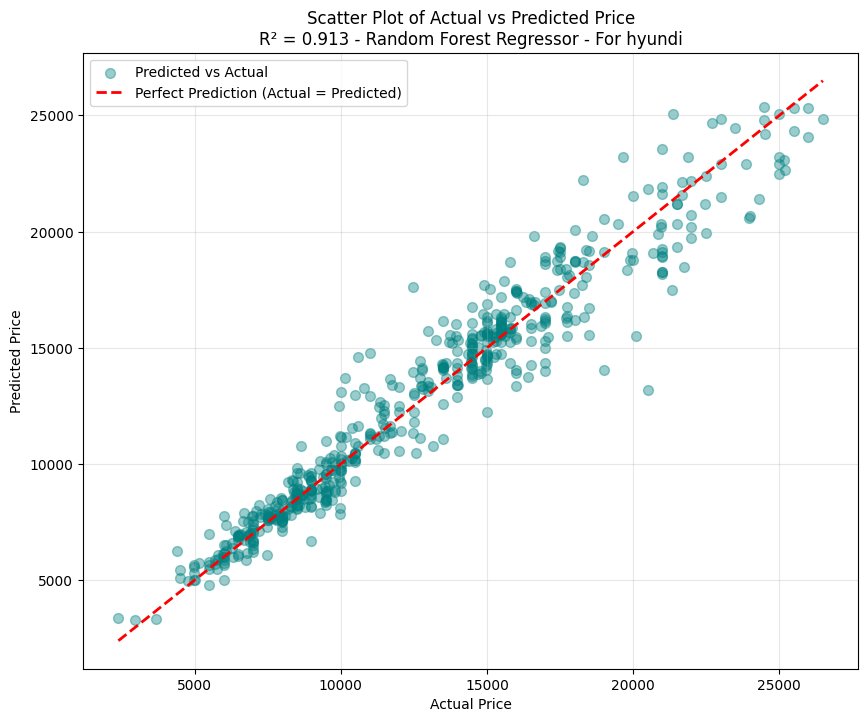

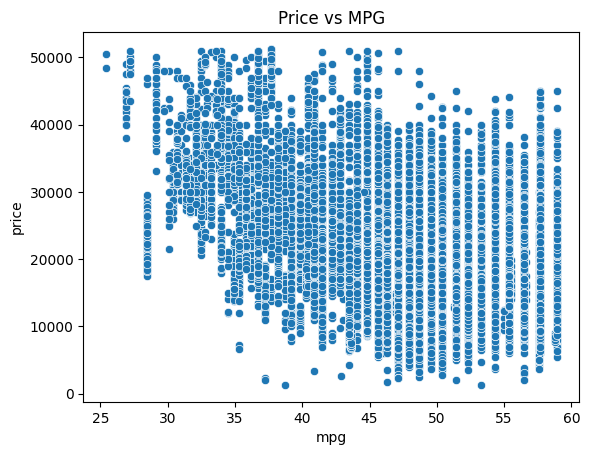

mercedes 23 23


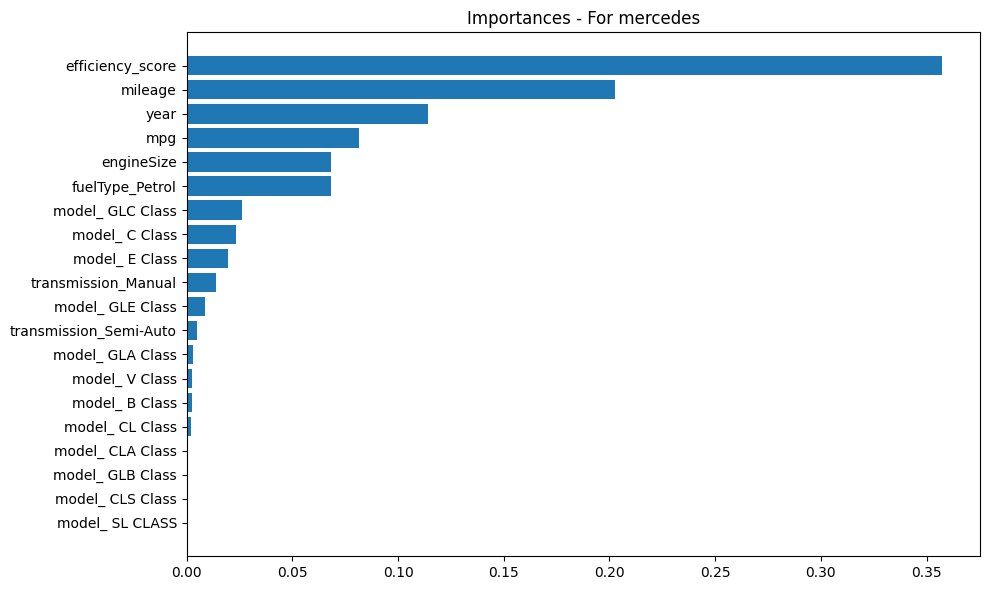

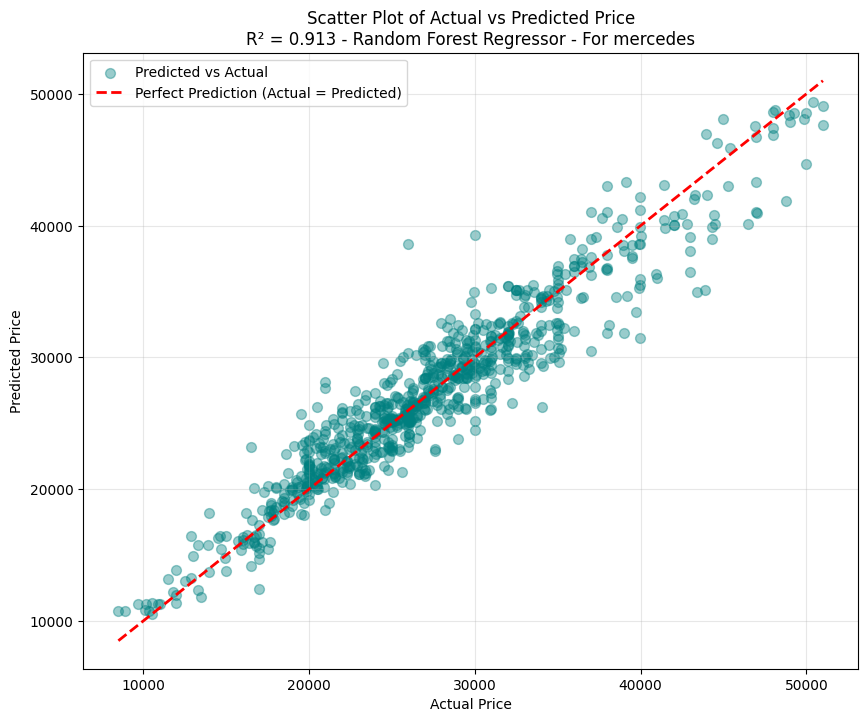

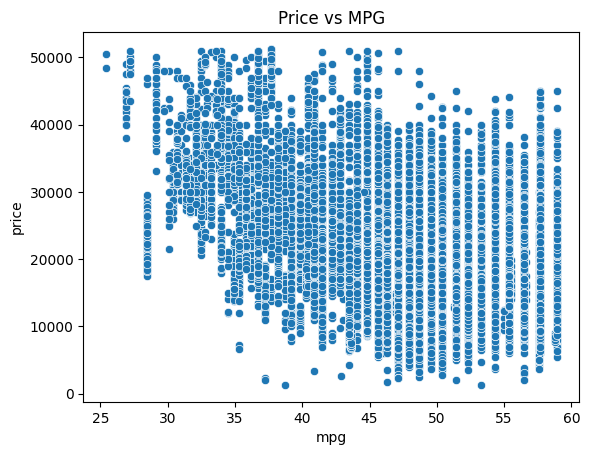

skoda 21 21


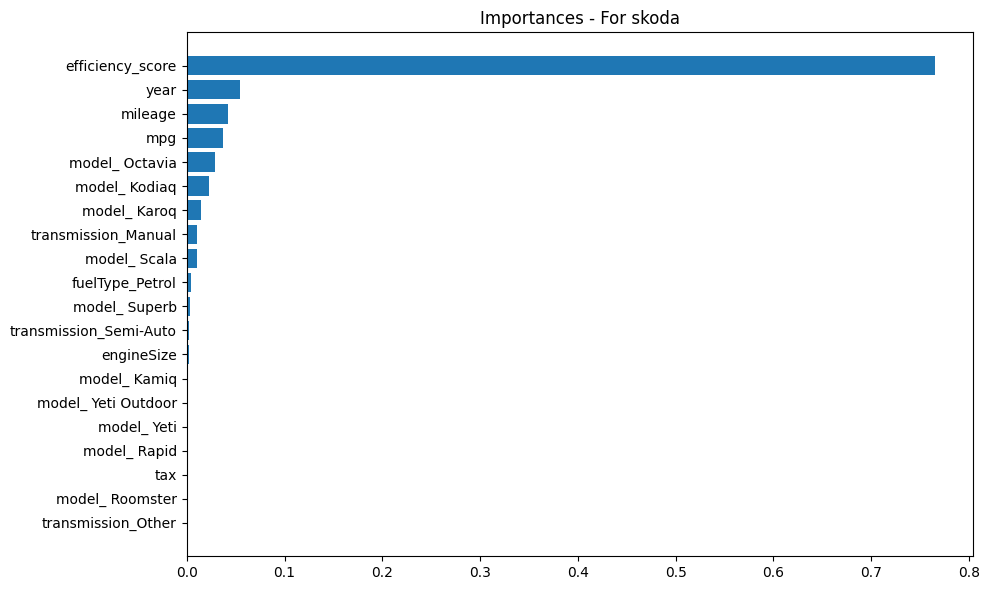

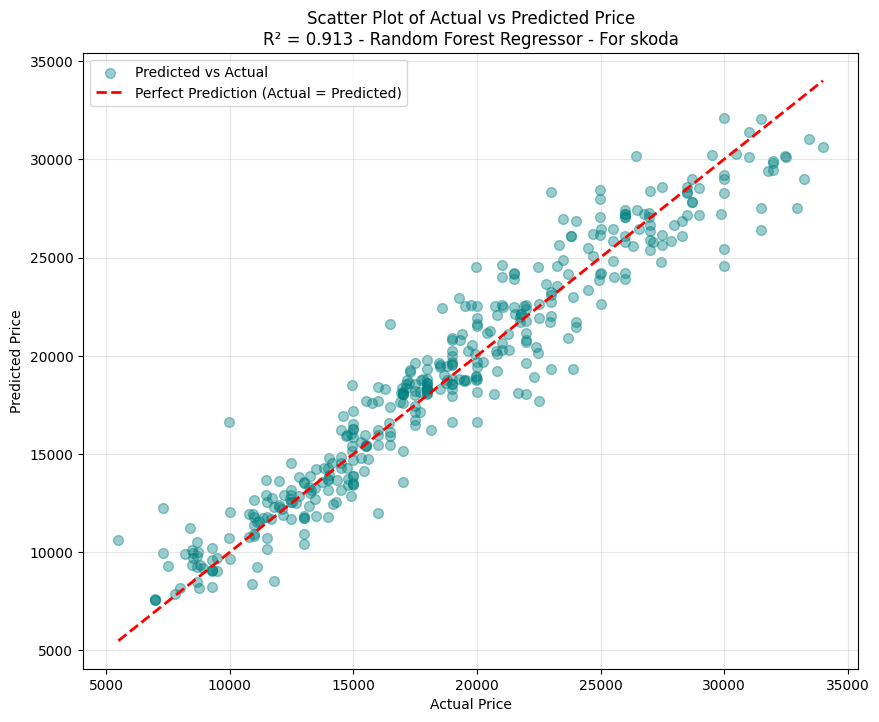

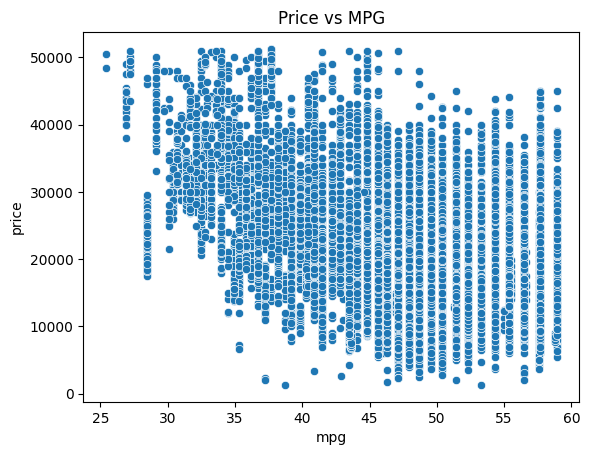

toyota 19 19


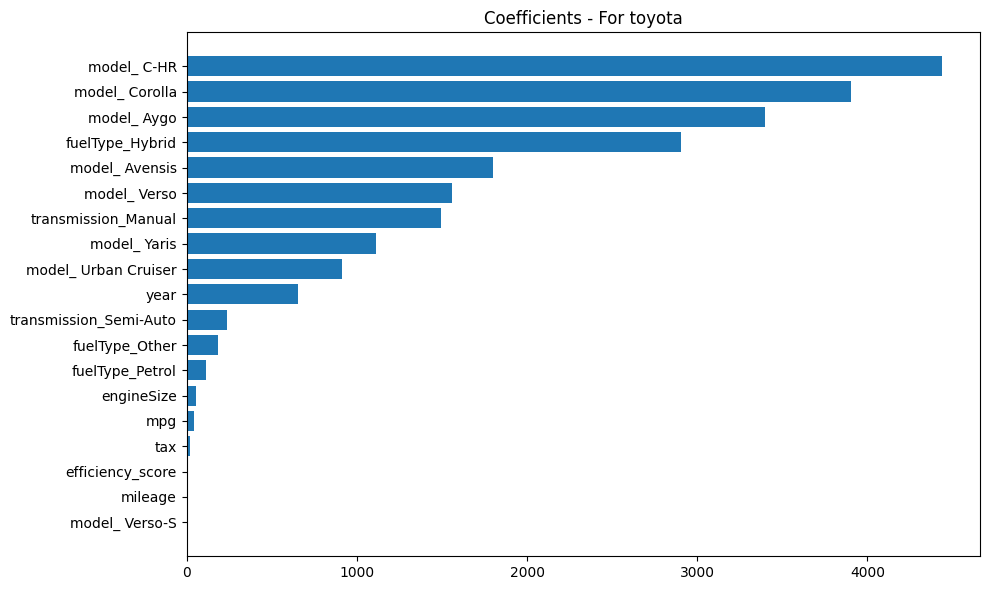

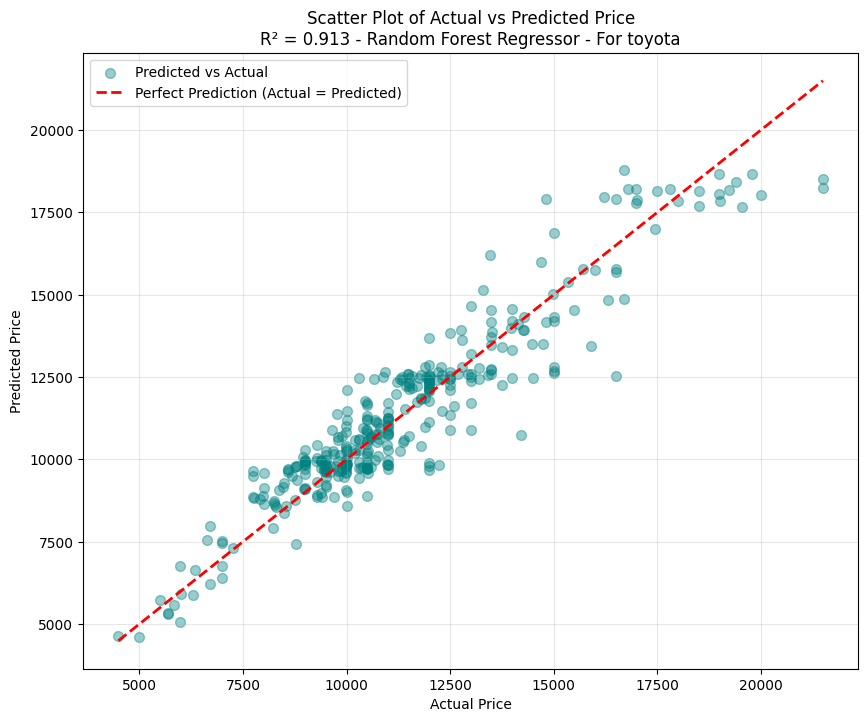

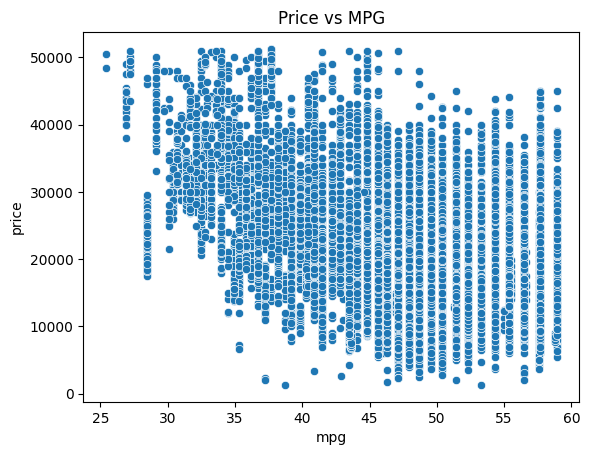

vauxhall 18 18


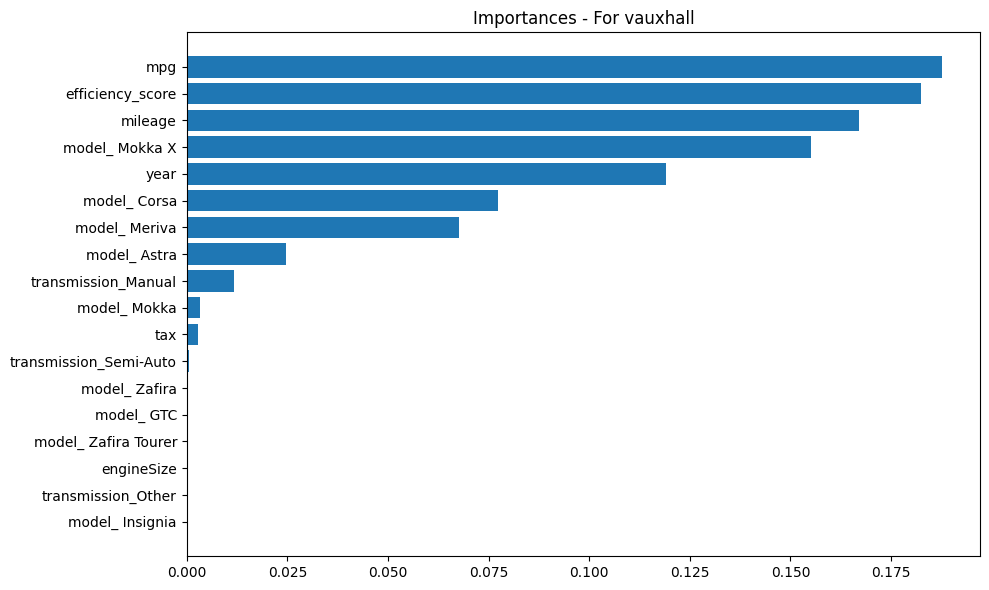

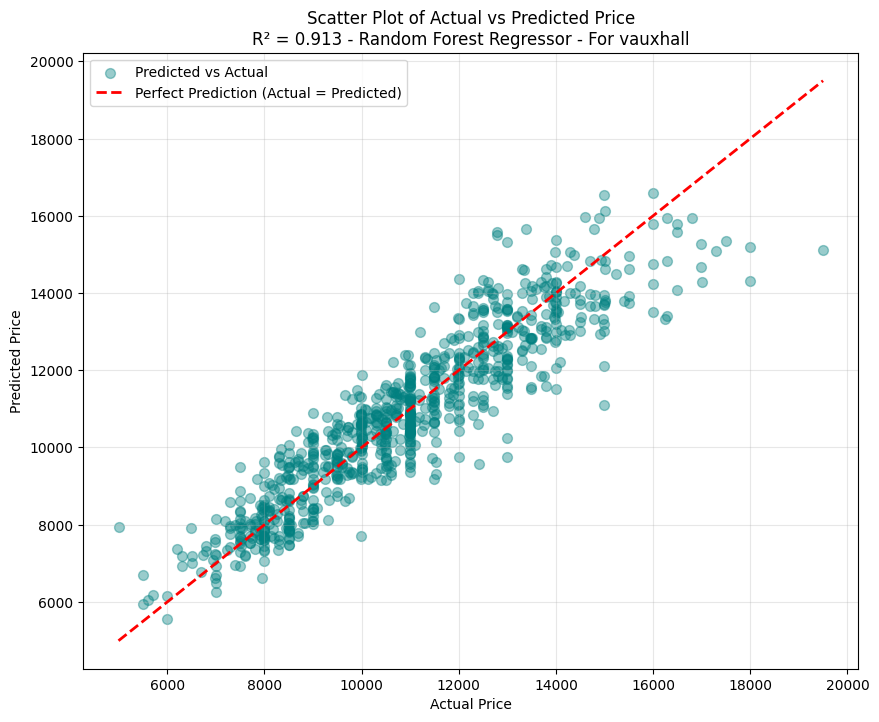

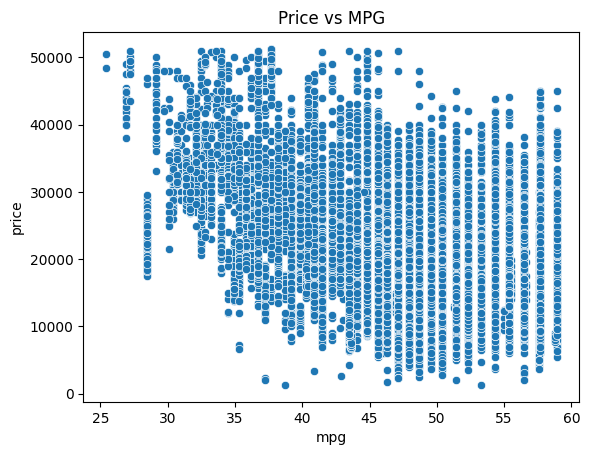

vw 32 32


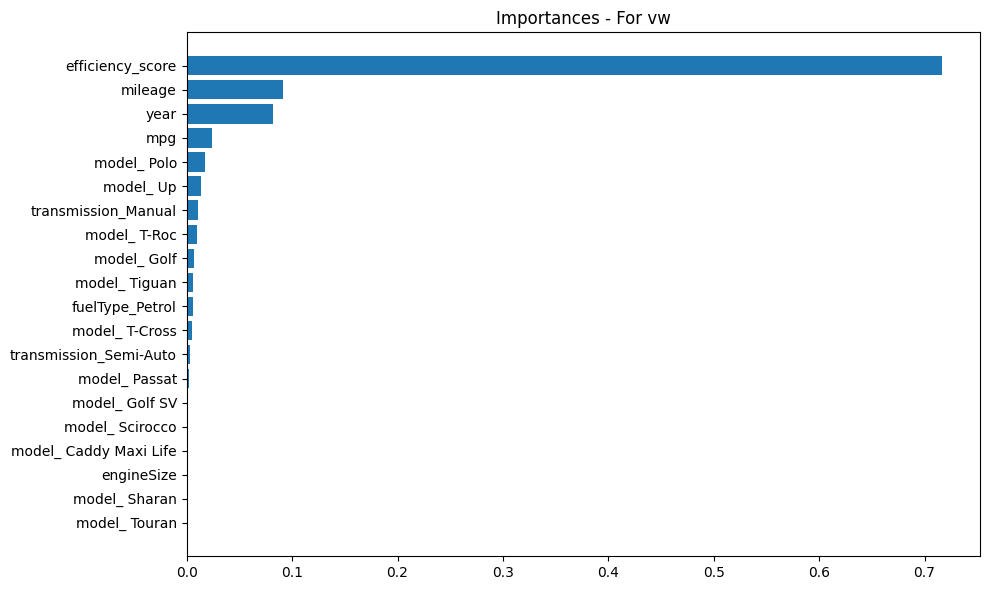

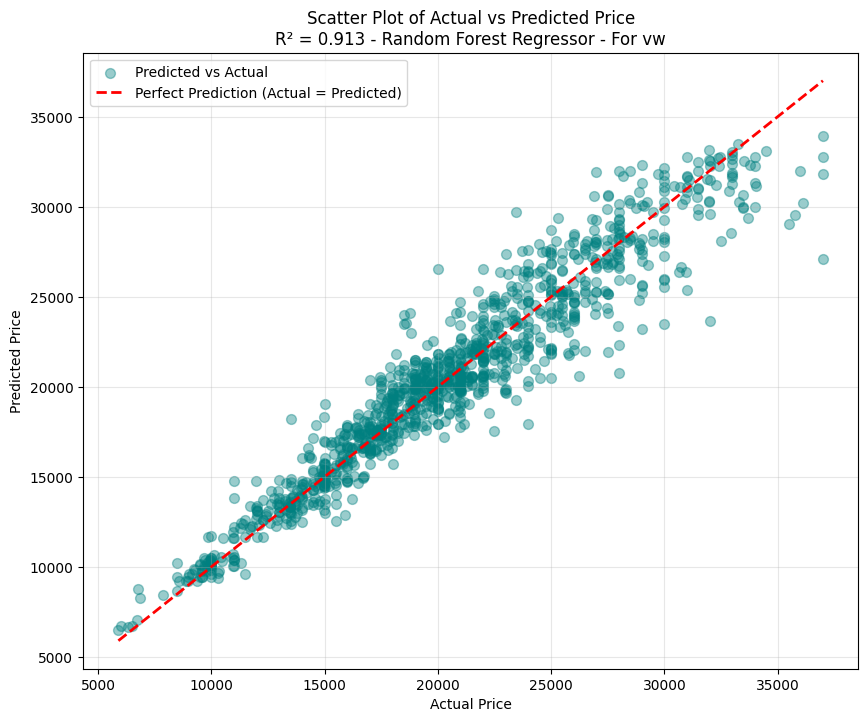

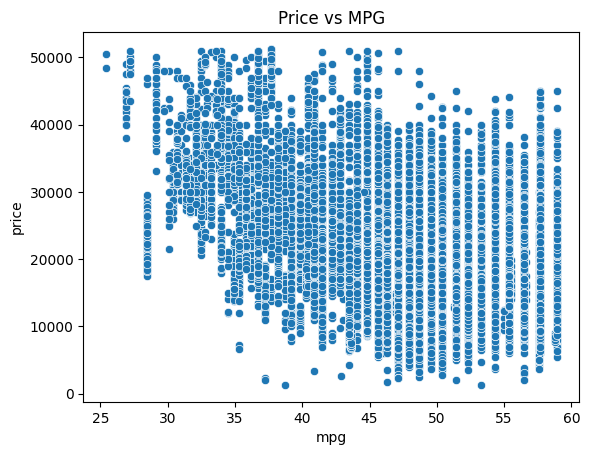

In [ ]:
for make_vehicle, data in trained_models_per_make.items():
	model = data["model"]
	feature_names = data["feature_names"]
	y_test = data['y_test']
	predictions = data['predictions']

	values, kind = features.get_feature_effects(model)

	n = model.n_features_in_
	feature_names = feature_names[:n]
	values = values[:n]
 
	visualisation.plot_feature_importances(
		values,
		feature_names,
		f"{kind.title()}s - For {make_vehicle}"
	)
 

	visualisation.plot_actual_vs_predicted(y_test, predictions, f'Random Forest Regressor - For {make_vehicle}', metrics['R2'])
	visualisation.plot_price_vs_mpg(df)